In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'toxic-commands-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5127578%2F8575067%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240601%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240601T223816Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7e02b2e2a8774641ed86f86355dd987a60f9a9b0fa57772ea9d4769a35f9d5c79772ceccc09a00c8af433718937a1fc5fa9d16aae7776352122ddd4073d0a7d04b4bb2809570d4dd2bf87151fca98c3176cab188f1ba0abf1a347c82caea91b528ea635e6c233168ca2a76a5f938b3b0a5cf59f1bb4b38bcacdd2b8f91ca9cfa52e43ec2d309c2747d27c75f7b6e4734d24063475048fccaeed2a261a925d05c62980e34a297361074523695e04fdf048669b691a569ea70d506a4b5ade406f42689007bb64e89f7caece0afee781a79fe9e7ba287f77102f7764c47587ba74153ebeea6b914b5363e17cf56c599297211525e55423bf7c5d5a208492fb49ac8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 54496444 bytes downloaded
Downloaded and uncompressed: toxic-commands-data
Data source import complete.


# Importing Libraries

In [ ]:
pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 2.0 MB/s eta 0:00:00


In [ ]:
pip install imbalanced-learn

In [ ]:
## Data Collection and Manipulation
import pandas as pd
import numpy as np

## Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preprocessing
import nltk
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report
from wordcloud import WordCloud
import re
import emoji

# UnderSampling
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
## Model Creation
import tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, SpatialDropout1D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from transformers import BertTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /root/nltk_data...


# Load the Data

In [ ]:
train = pd.read_csv("/kaggle/input/toxic-commands-data/train.csv")
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
train.drop("id", axis=1, inplace=True)
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
test = pd.read_csv("/kaggle/input/toxic-commands-data/test.csv")
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
test_y = pd.read_csv("/kaggle/input/toxic-commands-data/test_labels.csv")
test_y.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [ ]:
test = pd.merge(test, test_y, on = "id")
test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


In [ ]:
test = test.drop(test[test["toxic"] == -1].index)
test.drop("id", axis=1, inplace=True)
test.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,Thank you for understanding. I think very high...,0,0,0,0,0,0
7,:Dear god this site is horrible.,0,0,0,0,0,0
11,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
13,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
14,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


In [ ]:
train["toxic"].value_counts()

toxic
0    144277
1     15294
Name: count, dtype: int64

In [ ]:
test["toxic"].value_counts()

toxic
0    57888
1     6090
Name: count, dtype: int64

# Exploratory Data Analysis (EDA)

<Axes: xlabel='comment_text'>

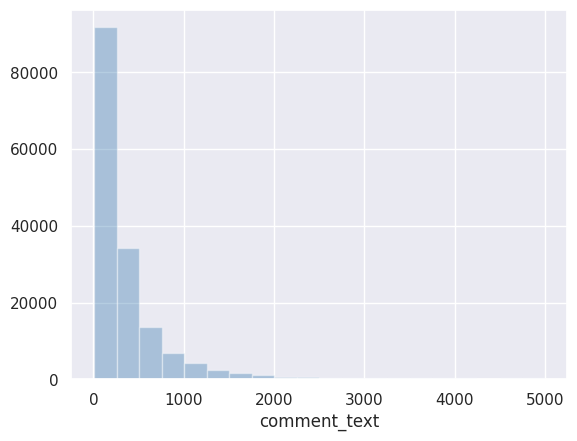

In [ ]:
sns.set(color_codes=True)
comment_len = train.comment_text.str.len()
sns.distplot(comment_len, kde=False, bins=20, color="steelblue")

In [ ]:
train_labels = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
label_count = train_labels.sum()

<Axes: title={'center': 'Labels Frequency'}>

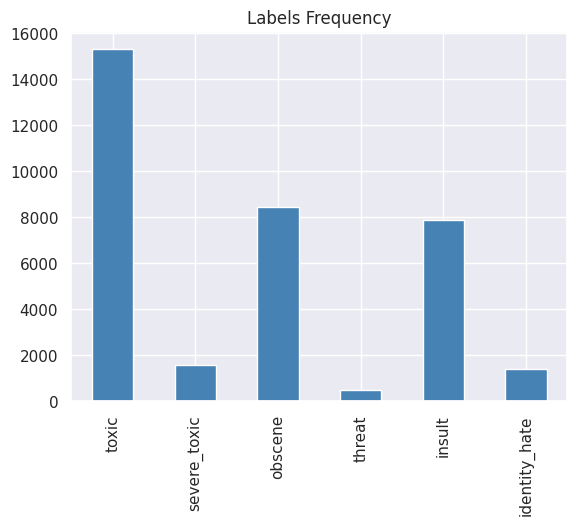

In [ ]:
label_count.plot(kind='bar', title='Labels Frequency', color='steelblue')

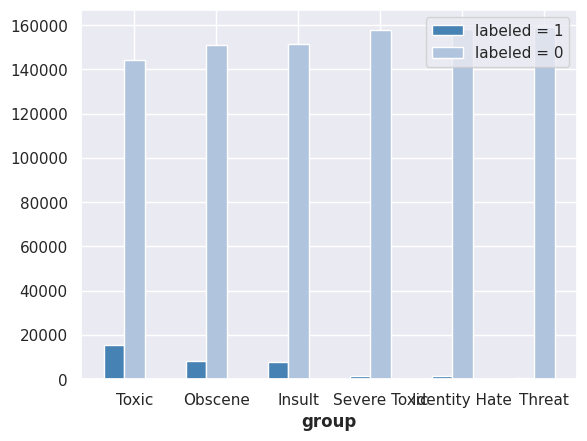

In [ ]:
barWidth = 0.25

bars1 = [sum(train['toxic'] == 1), sum(train['obscene'] == 1), sum(train['insult'] == 1), sum(train['severe_toxic'] == 1),
         sum(train['identity_hate'] == 1), sum(train['threat'] == 1)]
bars2 = [sum(train['toxic'] == 0), sum(train['obscene'] == 0), sum(train['insult'] == 0), sum(train['severe_toxic'] == 0),
         sum(train['identity_hate'] == 0), sum(train['threat'] == 0)]

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='steelblue', width=barWidth, label='labeled = 1')
plt.bar(r2, bars2, color='lightsteelblue', width=barWidth, label='labeled = 0')

plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate',
                                                       'Threat'])
plt.legend()
plt.show()

<Axes: >

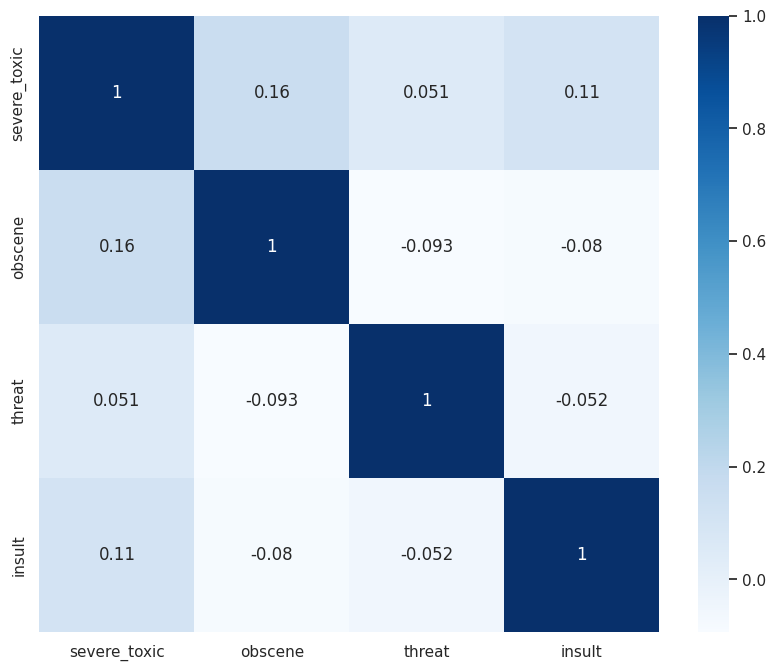

In [ ]:
rowsums = train.iloc[:, 2:].sum(axis=1)
temp = train.iloc[:, 2:-1]
train_corr = temp[rowsums > 0]
corr = train_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, cmap="Blues")

# Data Preprocessing

In [ ]:
train.isnull().sum()

comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [ ]:
test.isnull().sum()

comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [ ]:
import nltk
nltk.download('wordnet')


def preprocess_text(text,remove_repeat_text=True, remove_patterns_text=True, is_lower=True):

    if is_lower:
      text=text.lower()

    if remove_repeat_text:
      text = re.sub(r'(.)\1{2,}', r'\1', text)

    if isinstance(text, list):
        text = ' '.join(text)


    text = str(text).replace("\n", " ")


    text = re.sub(r'[^\w\s]',' ',text)


    text = re.sub('[0-9]',"",text)


    text = re.sub(" +", " ", text)


    text = re.sub("([^\x00-\x7F])+"," ",text)




    return text

train["cleaned_comments"] = train["comment_text"].apply(preprocess_text)
test["cleaned_comments"] = test["comment_text"].apply(preprocess_text)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
train["cleaned_comments"][0]

'explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now '

In [ ]:
test.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_comments
5,Thank you for understanding. I think very high...,0,0,0,0,0,0,thank you for understanding i think very highl...
7,:Dear god this site is horrible.,0,0,0,0,0,0,dear god this site is horrible
11,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0,somebody will invariably try to add religion ...
13,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0,it says it right there that it is a type the ...
14,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0,before adding a new product to the list make ...


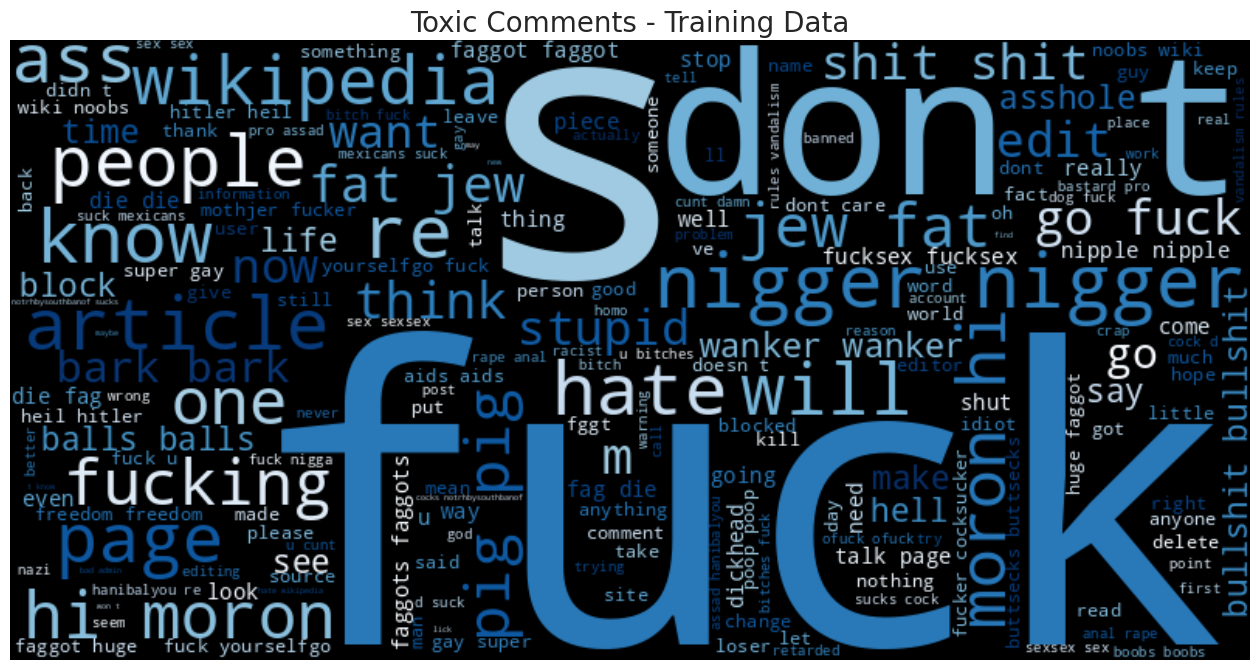

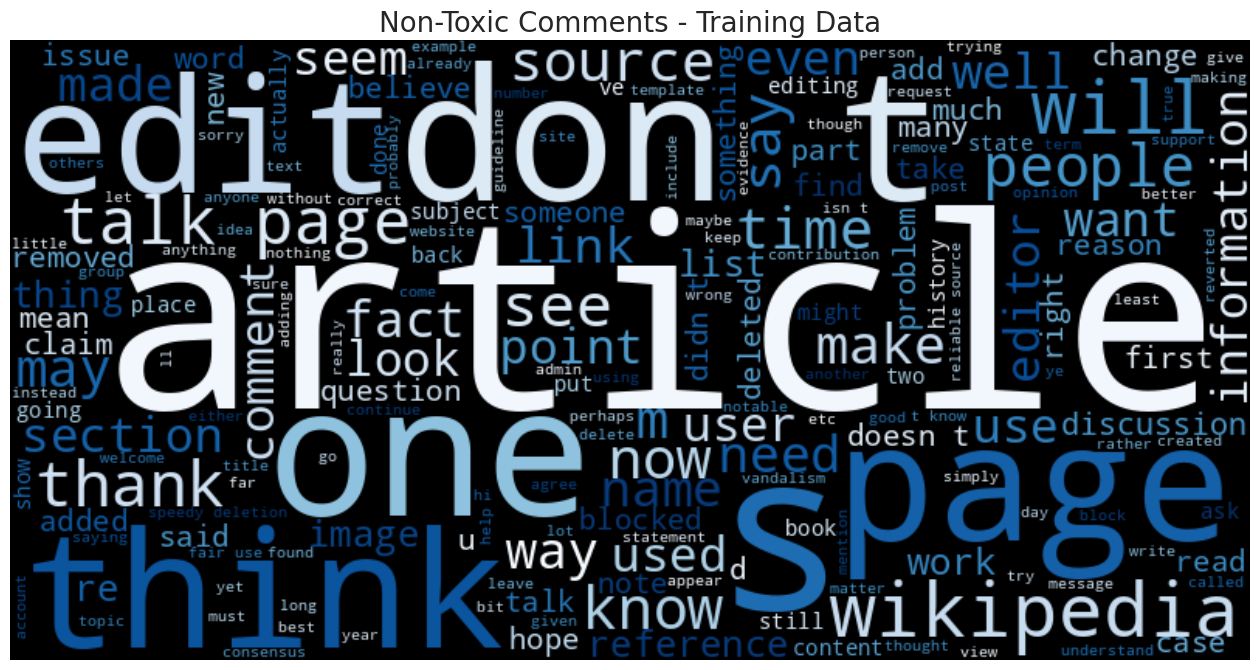

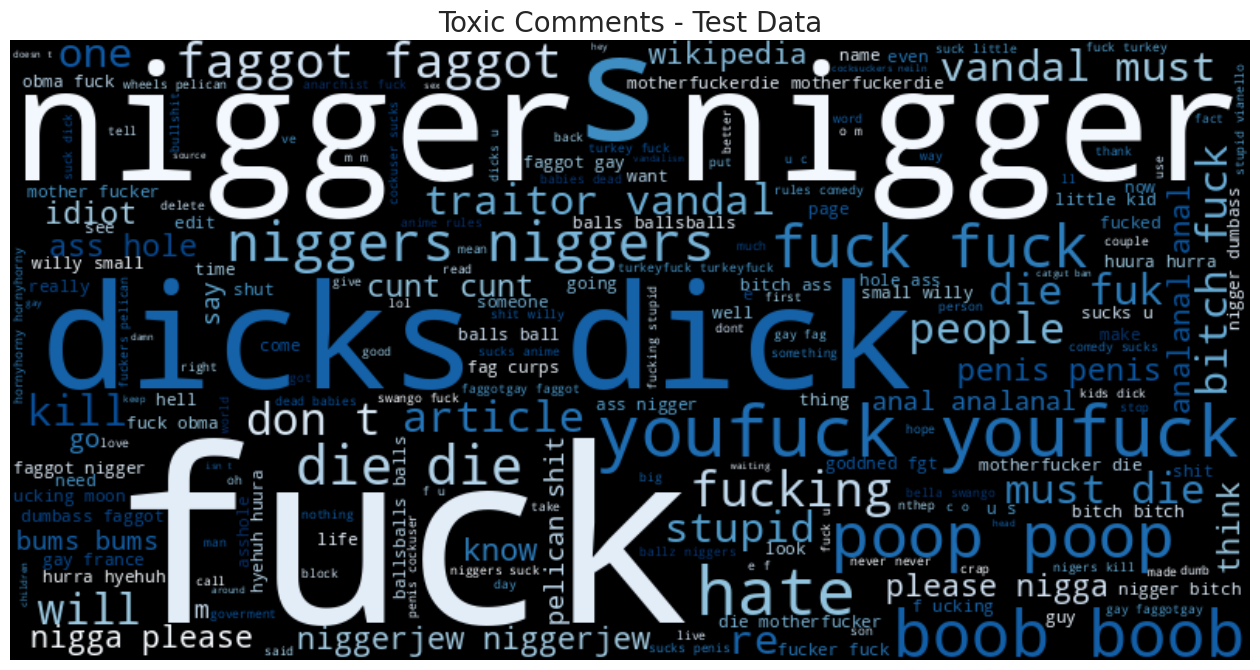

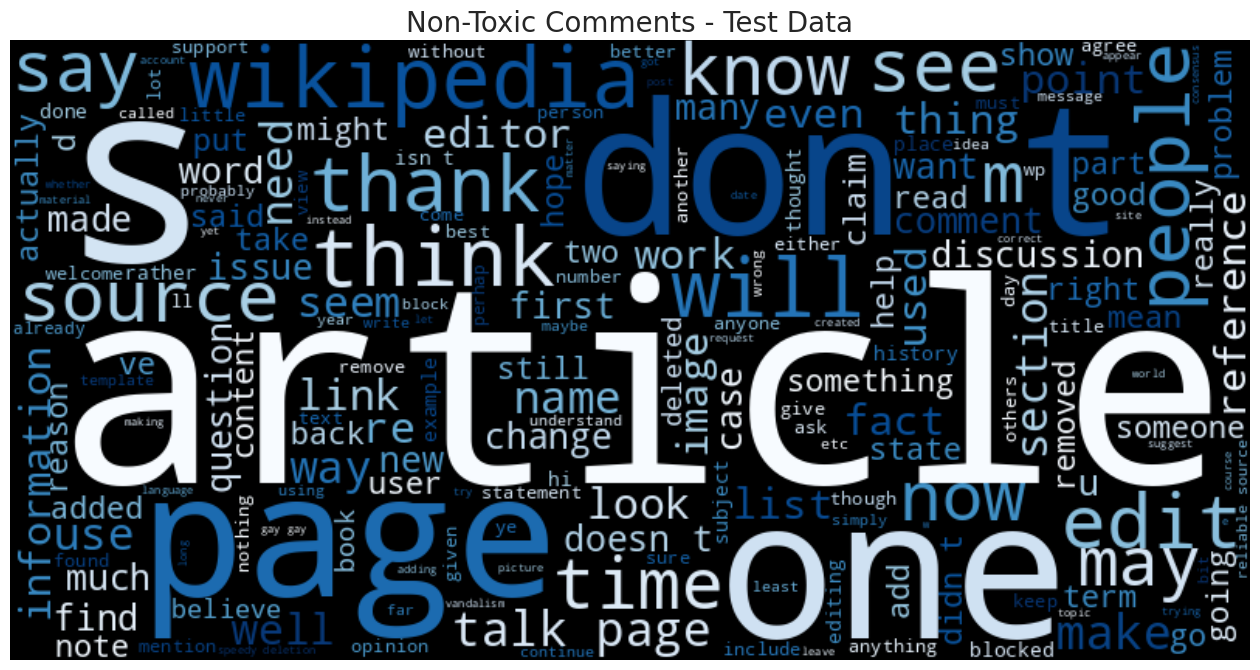

In [ ]:
def generate_wordcloud(data, label):
    text = ' '.join(data[data['toxic'] == label]['cleaned_comments'])
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)
    return wordcloud

# Training data word clouds
train_toxic_wordcloud = generate_wordcloud(train, 1)
train_nontoxic_wordcloud = generate_wordcloud(train, 0)

# Test data word clouds
test_toxic_wordcloud = generate_wordcloud(test, 1)
test_nontoxic_wordcloud = generate_wordcloud(test, 0)

# Plot the word clouds
plt.figure(figsize=(16, 12))

plt.imshow(train_toxic_wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
plt.title('Toxic Comments - Training Data', size=20)
plt.axis('off')
plt.show()

plt.figure(figsize=(16, 12))
plt.imshow(train_nontoxic_wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
plt.title('Non-Toxic Comments - Training Data', size=20)
plt.axis('off')
plt.show()

plt.figure(figsize=(16, 12))
plt.imshow(test_toxic_wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
plt.title('Toxic Comments - Test Data', size=20)
plt.axis('off')
plt.show()

plt.figure(figsize=(16, 12))
plt.imshow(test_nontoxic_wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
plt.title('Non-Toxic Comments - Test Data', size=20)
plt.axis('off')
plt.show()


In [ ]:
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def preprocess_text(text):

    tokens = word_tokenize(text)


    filtered_tokens = [token.lower() for token in tokens if token.lower() not in stop_words]


    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]


    preprocessed_text = " ".join(lemmatized_tokens)

    return preprocessed_text


train['comment_text'] = train['cleaned_comments'].apply(preprocess_text)
test['comment_text'] = test['cleaned_comments'].apply(preprocess_text)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
train["cleaned_comments"][0]

'explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now '

In [ ]:
train["comment_text"][0]

'explanation edits made username hardcore metallica fan reverted vandalism closure gas voted new york doll fac please remove template talk page since retired'

# UnderSampling

In [ ]:
X_train = train["comment_text"].values
y_train = np.array(train["toxic"])

In [ ]:
X_test = test["comment_text"].values
y_test = np.array(test["toxic"])

In [ ]:
print("Original training data distribution:", Counter(y_train))

Original training data distribution: Counter({0: 144277, 1: 15294})


In [ ]:
print("Original testing data distribution:", Counter(y_test))

Original testing data distribution: Counter({0: 57888, 1: 6090})


In [ ]:
rus = RandomUnderSampler(random_state=42)

In [ ]:
X_resampled_train, y_resampled_train = rus.fit_resample(X_train.reshape(-1, 1), y_train)

In [ ]:
print("Sampling training data distribution:", Counter(y_resampled_train))

Sampling training data distribution: Counter({0: 15294, 1: 15294})


In [ ]:
X_resampled_test, y_resampled_test = rus.fit_resample(X_test.reshape(-1, 1), y_test)

In [ ]:
print("Sampling testing data distribution:", Counter(y_resampled_test))

Sampling testing data distribution: Counter({0: 6090, 1: 6090})


In [ ]:
X_resampled_train = pd.DataFrame(X_resampled_train, columns=["comment_text"])
y_resampled_train = pd.Series(y_resampled_train, name="toxic")

In [ ]:
X_resampled_test = pd.DataFrame(X_resampled_test, columns=["comment_text"])
y_resampled_test = pd.Series(y_resampled_test, name="toxic")

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
y_resampled_train

0        0
1        0
2        0
3        0
4        0
        ..
30583    1
30584    1
30585    1
30586    1
30587    1
Name: toxic, Length: 30588, dtype: int64

In [ ]:
X_resampled_test

,comment_text
0,formatting nice requires lot patience would better u try previous list well though know tedious job u
1,clear answer sort situation tend towards view letting blocked editor find keep creating sockpuppets blocked matter edits stay anyway encourages keep socking whereas letting find waste time whatever sockpuppets get reverted deleted encourages stop reason usually delete situation however see case view useful image still useful even though uploaded violation block criticise take different view editor us pseudonym
2,since edit warring article going time editor often involved reverting banned continuing edit act impact account well two others group ip information seen administrator noticeboard listing permanent link course prevent editing talk page join consensus discussion development article time go editor engage dispute resolution without additional problem restriction may lifted meant endorse particular version article avoid continuous overriding content inappropriate mean resolving dispute problem continues next step may block editor involved shut article editing
3,copyright violation upload others image call infringing copyright edits reverted
4,inserted edit unknown user following passage andrica conjecture rewritten simply state inserted see expression simply simpler provided text please discus
...,...
12175,sorry dickhead cannae help douche bag dumbass bitch boy please would like change lifeless loser
12176,nigel crazy idiot
12177,fourth baldrick possibly cleverer made anyone else share belief proof fourth baldrick stupidity possibly show clever small indeed
12178,iran right iran drone spreading homosexual western idea iran call bone drone get used fabulous bearded mullah let say wording used recent iran incident misleading best people know international airspace start nautical mile coast saying incident supposedly definitely keep supposedly unless believe professional liar spin doctor feed like word dog surprise considering massive influx right wing scum shill provocateur invaded wikipedia past year turned cesspool happened mile iran make sense make sense tell god damned mother fucking truth say supposedly occurred four mile iranian air space usa supposedly using expensive operate piece military equipment surveillance recon open ocean water navy bird watching flora fauna type shit especially close iran extensive military industrial facility leader totally admitted violate iran airspace time continue despite loss drone supposedly hacked whatever happened hello mr semi retired biased rash inflammatory speculative antagonistic sensationalist article cited actually back modification made incident occurred supposedly mile iran air space better source might christian science monitor article recently published issue much thorough lack sensationalism article mr right wing nut job liked eye eye semen


In [ ]:
X_train_resampled, X_val_resampled, y_train_resampled, y_val_resampled = train_test_split(
    X_resampled_train["comment_text"],
    y_resampled_train,
    test_size=0.2,
    random_state=42
)

In [ ]:
X_train_resampled

26276                                                                                                                                                                                                                                                                                                                     feel argument dumb please feel free disappear miss national bias point day rigged poll ran mega cd page rename non notable yank name without editor aware time respond refute name change another snatch grab name nationalist yank
27921                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [ ]:
X_val_resampled

16303                                                                               wack pack fucking insane drunk power instead totally removing big howard stern guy like crackhead bob fred elephant boy remove part majesty find offensive
6576                                                                                                                                    hornswaggle popular mi spell due juggalo championshit wrestling wrestler named hornswaggling hillbilly
18911                                                                                                        revert lot people work improve wiki motherfucker dare block user user reverted destructive activite shame shitface anna frodesiak
624                                                                                                                                                          happy anniversary frickative hope arrive time see start next five year fine style
7739                                        

In [ ]:
X_resampled_test

,comment_text
0,formatting nice requires lot patience would better u try previous list well though know tedious job u
1,clear answer sort situation tend towards view letting blocked editor find keep creating sockpuppets blocked matter edits stay anyway encourages keep socking whereas letting find waste time whatever sockpuppets get reverted deleted encourages stop reason usually delete situation however see case view useful image still useful even though uploaded violation block criticise take different view editor us pseudonym
2,since edit warring article going time editor often involved reverting banned continuing edit act impact account well two others group ip information seen administrator noticeboard listing permanent link course prevent editing talk page join consensus discussion development article time go editor engage dispute resolution without additional problem restriction may lifted meant endorse particular version article avoid continuous overriding content inappropriate mean resolving dispute problem continues next step may block editor involved shut article editing
3,copyright violation upload others image call infringing copyright edits reverted
4,inserted edit unknown user following passage andrica conjecture rewritten simply state inserted see expression simply simpler provided text please discus
...,...
12175,sorry dickhead cannae help douche bag dumbass bitch boy please would like change lifeless loser
12176,nigel crazy idiot
12177,fourth baldrick possibly cleverer made anyone else share belief proof fourth baldrick stupidity possibly show clever small indeed
12178,iran right iran drone spreading homosexual western idea iran call bone drone get used fabulous bearded mullah let say wording used recent iran incident misleading best people know international airspace start nautical mile coast saying incident supposedly definitely keep supposedly unless believe professional liar spin doctor feed like word dog surprise considering massive influx right wing scum shill provocateur invaded wikipedia past year turned cesspool happened mile iran make sense make sense tell god damned mother fucking truth say supposedly occurred four mile iranian air space usa supposedly using expensive operate piece military equipment surveillance recon open ocean water navy bird watching flora fauna type shit especially close iran extensive military industrial facility leader totally admitted violate iran airspace time continue despite loss drone supposedly hacked whatever happened hello mr semi retired biased rash inflammatory speculative antagonistic sensationalist article cited actually back modification made incident occurred supposedly mile iran air space better source might christian science monitor article recently published issue much thorough lack sensationalism article mr right wing nut job liked eye eye semen


# Model Building

In [ ]:
# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode(data, tokenizer, max_length=150):
    encoded_data = tokenizer.batch_encode_plus(
        data,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )
    return encoded_data['input_ids'], encoded_data['attention_mask']

# Encode the datasets
X_train_input_ids, X_train_attention_masks = encode(X_train_resampled, tokenizer)
X_val_input_ids, X_val_attention_masks = encode(X_val_resampled, tokenizer)
X_test_input_ids, X_test_attention_masks = encode(X_resampled_test["comment_text"], tokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
X_train_input_ids

<tf.Tensor: shape=(24470, 150), dtype=int32, numpy=
array([[  101,  2514,  6685, ...,     0,     0,     0],
       [  101,  3844,  6616, ...,     0,     0,     0],
       [  101,  7367,  4063, ...,     0,     0,     0],
       ...,
       [  101,  2512, 18562, ...,     0,     0,     0],
       [  101, 18138,  1052, ...,     0,     0,     0],
       [  101,  2175,  3995, ...,     0,     0,     0]], dtype=int32)>

In [ ]:
y_train = np.array(y_train_resampled)
y_val = np.array(y_val_resampled)
y_test = np.array(y_resampled_test)

In [ ]:
embedding_dim = 128
num_labels = 1
max_length = 150

model = Sequential()
model.add(Embedding(input_dim=tokenizer.vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=64, activation='tanh')))
model.add(Dense(num_labels, activation='sigmoid'))


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall

filepath = 'best_model.keras'

# Define the ModelCheckpoint callback with the specified filepath
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

# Define custom metrics
precision = Precision(name='precision')
recall = Recall(name='recall')

# List of callbacks to be used during training
callbacks = [checkpoint, early_stopping]

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 128)          3906816   
                                                                 
 bidirectional (Bidirection  (None, 150, 256)          263168    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 150, 256)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 4334465 (16.53 MB)
Trainable params: 43344

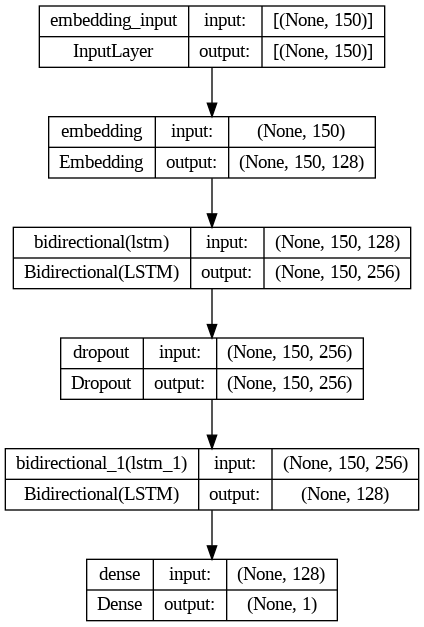

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    X_train_input_ids, y_train,
    epochs=5,  # You can increase the number of epochs for better performance
    batch_size=64,
    validation_data=(X_val_input_ids, y_val),
    verbose=1,
    callbacks=callbacks
)

Epoch 1/5
383/383 [==============================] - ETA: 0s - loss: 0.3188 - accuracy: 0.8609 - precision: 0.8676 - recall: 0.8533
Epoch 1: val_loss improved from inf to 0.23281, saving model to best_model.keras
383/383 [==============================] - 537s 1s/step - loss: 0.3188 - accuracy: 0.8609 - precision: 0.8676 - recall: 0.8533 - val_loss: 0.2328 - val_accuracy: 0.9011 - val_precision: 0.8797 - val_recall: 0.9246
Epoch 2/5
383/383 [==============================] - ETA: 0s - loss: 0.1676 - accuracy: 0.9377 - precision: 0.9348 - recall: 0.9417
Epoch 2: val_loss did not improve from 0.23281
383/383 [==============================] - 521s 1s/step - loss: 0.1676 - accuracy: 0.9377 - precision: 0.9348 - recall: 0.9417 - val_loss: 0.2589 - val_accuracy: 0.8988 - val_precision: 0.9190 - val_recall: 0.8702
Epoch 3/5
383/383 [==============================] - ETA: 0s - loss: 0.1191 - accuracy: 0.9577 - precision: 0.9526 - recall: 0.9638
Epoch 3: val_loss did not improve from 0.23281
3

In [ ]:
loss, accuracy, precision, recall = model.evaluate(X_test_input_ids, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)

381/381 [==============================] - 103s 269ms/step - loss: 0.4623 - accuracy: 0.8736 - precision: 0.8380 - recall: 0.9261
Test Loss: 0.4623143970966339
Test Accuracy: 0.8735632300376892
Test Precision: 0.8380386233329773
Test Recall: 0.9261083602905273


In [ ]:
y_pred = model.predict(X_test_input_ids)

381/381 [==============================] - 106s 275ms/step


In [ ]:
y_pred

array([[1.2340156e-03],
       [1.1388607e-03],
       [5.4922997e-04],
       ...,
       [7.0053252e-04],
       [1.4712186e-01],
       [9.9875194e-01]], dtype=float32)

In [ ]:


# Convert probabilities to binary labels using a threshold of 0.5
threshold = 0.68
y_test_pred_labels = (y_pred >= threshold).astype(int)



# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred_labels))



Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      6090
           1       0.85      0.91      0.88      6090

    accuracy                           0.87     12180
   macro avg       0.88      0.87      0.87     12180
weighted avg       0.88      0.87      0.87     12180



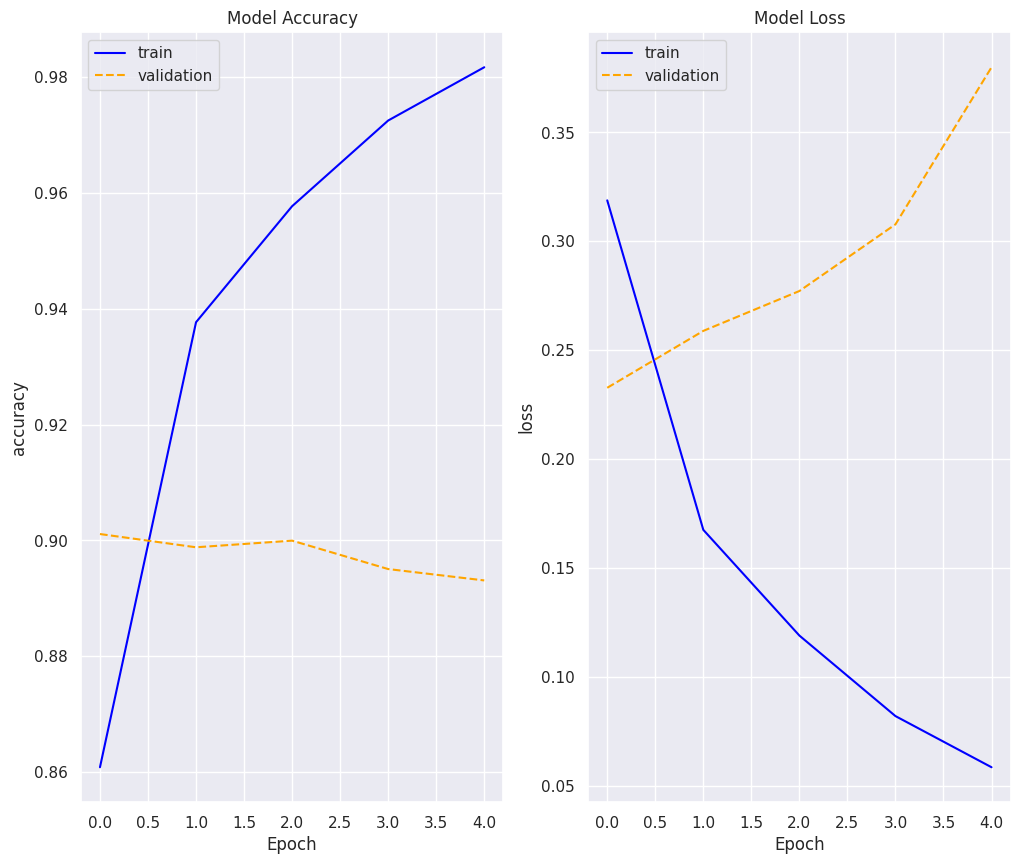

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,10))

ax[0].plot(history.history['accuracy'], label='Training Accuracy', linestyle='-', color='blue')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--', color='orange')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('accuracy')
ax[0].legend(['train', 'validation'], loc='best')


ax[1].plot(history.history['loss'], label='Training Loss', linestyle='-', color='blue')
ax[1].plot(history.history['val_loss'], label='Validation Loss', linestyle='--', color='orange')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('loss')
ax[1].legend(['train', 'validation'], loc='best')


381/381 [==============================] - 104s 274ms/step


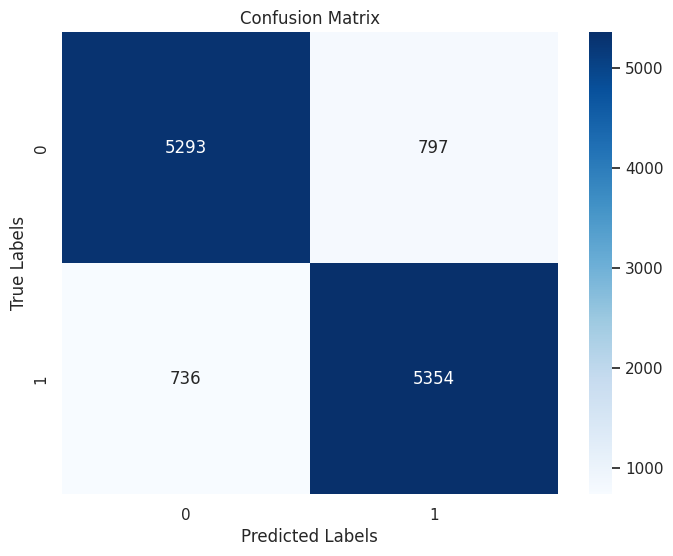

In [ ]:
from sklearn.metrics import confusion_matrix


predictions = model.predict(X_test_input_ids)
true_labels = y_test


binary_predictions = (predictions > 0.88).astype(int)


cm = confusion_matrix(true_labels, binary_predictions)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Saving a Model with Pickle

In [ ]:
import pickle



pickle.dump(model, open("toxicity_model.pkt", "wb"))

pickle.dump(tokenizer, open("bert_tokenizer.pkt", "wb"))

In [ ]:

save_directory = '/content/drive/My Drive/bert_tokenizer'
# Assuming 'tokenizer' is your trained Tokenizer
tokenizer.save_pretrained(save_directory)

('/content/drive/My Drive/bert_tokenizer/tokenizer_config.json',
 '/content/drive/My Drive/bert_tokenizer/special_tokens_map.json',
 '/content/drive/My Drive/bert_tokenizer/vocab.txt',
 '/content/drive/My Drive/bert_tokenizer/added_tokens.json')

In [67]:
prediction_Result = ["Non-Toxic", "Toxic"]

In [71]:

i, m = encode(['you are stupid boy'], tokenizer)
a = model.predict(i)
temp = a[0][0]
if temp > 0.73:
  print(prediction_Result[1])
else:
  print(prediction_Result[0])

1/1 [==============================] - 0s 131ms/step
Toxic


In [72]:
i, m = encode(['i love nature'], tokenizer)
a = model.predict(i)
temp = a[0][0]
if temp > 0.73:
  print(prediction_Result[1])
else:
  print(prediction_Result[0])

1/1 [==============================] - 0s 90ms/step
Non-Toxic
